# K-Nearest Neighbors for Classification

So far we have trained machine learning models to predict quantitative targets. Such models are called _regression models_ (or _regressors_). Now we will train machine learning models to predict categorical targets. In other words, the goal is to "classify" observations as belonging to one category (class) or the other. These models are called _classification models_ (or _classifiers_). As with regression, in classification models the feature variables are usually a mix of categorical and quantitative variables. The difference between regression and classification is in the type of the target variable being predicted - quantitative or categorical.

In 2012, Brittany Wenger, a 17-year old high school student from Florida, won first place in the Google Science Fair. She built [a cloud-based application](http://cloud4cancer.appspot.com/) that predicts whether a patient has breast cancer, based on attributes observed in a biopsy of breast tissue. Her classifier, based on a type of machine learning model called a _neural network_, was 97.4% accurate, with a 99.1% sensitivity to malignancy. What do these numbers mean?

First, we read in the data that Brittany Wenger trained her classifier on. The observational units are samples from biopsies of breat tissue. The target variable **Class** denotes whether the tumor is benign (0) or malignant (1).



In [1]:
import pandas as pd

df_breast = pd.read_csv("http://dlsun.github.io/pods/data/breast-cancer.csv")
df_breast.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


We focus on just two features for now: **Clump Thickness** and **Uniformity of Cell Size**. Let's plot the training data, using color to represent the class label.

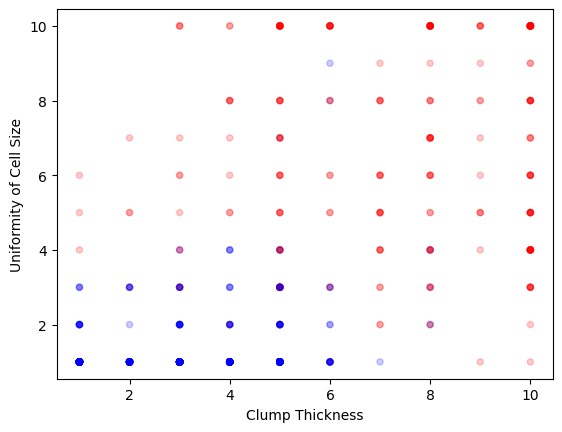

In [2]:
colors = df_breast["Class"].map({
    0: "blue",
    1: "red"
})

df_breast.plot.scatter(
    x="Clump Thickness", y="Uniformity of Cell Size", c=colors,
    alpha=.2
);

Now, suppose that we have a new sample of breast mass with clump thickness 6 and uniformity of cell size 7, represented by a black circle on the plot below. Is this likely a malignant or a benign tumor?

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/classification.png?raw=1)

It is not hard to guess that this tumor is probably malignant, just by looking at the plot. The reasoning goes like this: most of the breast masses in the training data that were "close" to this one were malignant, so it makes sense to predict that this mass is also malignant. This is the idea behind the $k$-nearest neighbors classifier:

1. Calculate the distance between the new point and each point in the training data, using some distance metric on the features.
2. Determine the $k$ closest points in the training data. Of these $k$ closest points, count up how many of each class label there are.
3. The predicted class of the new point is whichever class was most common among the $k$ closest points.

The only difference between the $k$-nearest neighbors classifier and the $k$-nearest neighbors regressor we have seen previously is the last step. Instead of averaging the labels of the $k$ neighbors to obtain our prediction, we count up the number of occurrences of each category among the labels and take the most common one. It makes sense that we have to do something different because the label is now categorical instead of quantitative. Remember: the analysis changes depending on the variable type!

# Implementing K-Nearest Neighbors from Scratch

We will eventually use a package to fit $k$-nearest neighbors classification, but it is instructive to first do it from scratch.


Let's classify the breast mass above using 10-nearest neighbors. First, we extract the training data and scale the features.

In [3]:
X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size"]]
y_train = df_breast["Class"]

X_train_sc = (X_train - X_train.mean()) / X_train.std()

Next, we create a `Series` for the new breast mass (with clump thickness 6 and uniformity of cell size 7), being sure to scale it in the same way as the training data.

In [4]:
x_new = pd.Series()
x_new["Clump Thickness"] = 6
x_new["Uniformity of Cell Size"] = 7

x_new_sc = (x_new - X_train.mean()) / X_train.std()
x_new_sc

Clump Thickness            0.552274
Uniformity of Cell Size    1.255795
dtype: float64

Now, we calculate the (Euclidean) distance between this new mass and each mass in the training data, and sort the distances from smallest to largest.

In [5]:
import numpy as np
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

3      0.326249
225    0.326249
304    0.326249
452    0.326249
499    0.326249
         ...   
116    2.640793
413    2.640793
113    2.640793
562    2.640793
354    2.640793
Length: 683, dtype: float64

The first 10 entries of this sorted list will be the 10 nearest neighbors. Let's get their index.

In [6]:
inds_nearest = dists_sorted.index[:10]
inds_nearest

Index([3, 225, 304, 452, 499, 251, 566, 652, 434, 550], dtype='int64')

Now we can look up these indices in the original data.

In [ ]:
df_breast.loc[inds_nearest]

As a quick reasonableness check, notice that these observations all have a clump thickness near 6 and a uniformity of cell size near 7. To make a prediction for the new mass, we need to count up how many malignant and benign masses there were among these 10-nearest neighbors.

In [7]:
df_breast.loc[inds_nearest]["Class"].value_counts()

Class
1    8
0    2
Name: count, dtype: int64

There were more malignant tumors, by an 8 to 2 margin, so the 10-nearest neighbors model predicts that the breast is malignant.

Classification models often report the predicted _probability_ of each label, instead of just the predicted label. In a $k$-nearest neighbors classification model, the predicted probability of a class is simply the proportion of the $k$ neighbors that are in that class. In the example above, instead of simply predicting that the breast mass is malignant, we could have instead said that it has an estimated $8/10 = 0.8$ probability of being malignant.

# K-Nearest Neighbors Classifier in Scikit-Learn

Now let's implement the same $10$-nearest neighbors model above using Scikit-Learn.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# define a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)

# fit the pipeline (using X_train and y_train defined above)
pipeline.fit(X_train, y_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

Compare the code above to what we have seen previously for $k$-nearest neighbors regression. The only difference is that `KNeighborsClassifier` replaces `KNeighborsRegressor`.

Now that we have fit the model we can use it to predict the class  of a new breast mass with clump thickness 6 and uniformity of cell size 7.

In [9]:
# define the test data (recall that scikit-learn expects a 2D-array)
pipeline.predict([[6, 7]])

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1])

The mass is predicted to be of class 1, malignant.

What if we want the predicted probabilities? For classification models, there is an additional method, `.predict_proba()`, that returns the predicted probability of each class.

In [10]:
pipeline.predict_proba([[6, 7]])

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.2, 0.8]])

The first number represents the probability of the first class (0 for benign) and the second number represents the probability of the second class (1 for malignant). Notice that the predicted probabilities add up to 1, as they must.

We can also use the model to make predictions for a series of observations. For example, we can use the model to predict the class for each observation in the training data.

In [11]:
pipeline.predict(X_train)

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

Or the predicted probabilities in each class for each observation in the training data.

In [12]:
pipeline.predict_proba(X_train)

array([[1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

For the training data, we can compare the predicted classes to the actual classes.

In [13]:
pd.crosstab(y_train, pd.Series(pipeline.predict(X_train), name = "Predicted"))

Predicted,0,1
Class,,
0,426,18
1,14,225


How can we evaluate the effectiveness of a classification model? We'll investigate that in the next notebook, but brainstorm some ideas before proceeding.